# Visualize CNN Weights and Activations

In [186]:
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import skimage.io
import skimage.transform
import skimage.filters
import keras
from keras.applications import vgg16
from keras import backend as K
from keras import models
import cv2

# Helper Functions

In [187]:
#Display shape, min, and max values of a tensor.
def tensor_summary(tensor):
    print("shape: {}  min: {}  max: {}".format(tensor.shape, tensor.min(), tensor.max()))

#Takes a tensor of 3 dimensions (height, width, colors)
#normalizes it's values to be between 0 and 1 so it's suitable for displaying as an image.
def normalize(image):
    image = image.astype(np.float32)
    return (image - image.min()) / (image.max() - image.min() + 1e-5)

def display_images(images, titles=None, cols=5, interpolation=None, cmap="Greys_r"):

#images: A list of images.(圖片列表)
#ndarray - A list of Numpy arrays. Each array represents an image.
#concatenate array(images)- A list of lists of Numpy arrays. 
              #In this case,the images in the inner lists are concatentated to make one image.

    titles = titles or [""] * len(images)
    rows = math.ceil(len(images) / cols)
    height_ratio = 1.2 * (rows/cols) * (0.5 if type(images[0]) is not np.ndarray else 1)
    plt.figure(figsize=(15, 15 * height_ratio))
    i = 1
    #用zip同時迭代images跟titles，每個元素以一對一的方式配對起來/zip對不同長度的以短的為準
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.axis("off")#關閉軸

        if type(image) is not np.ndarray:
            image = [normalize(g) for g in image]
            image = np.concatenate(image, axis=1)
        else:
            image = normalize(image)
        plt.title(title, fontsize=9)
        plt.imshow(image, cmap=cmap, interpolation=interpolation)
        i += 1

# Build VGG16 Convolutional Network

In [188]:
# Build a VGG16 Convolutional Network pre-trained on ImageNet
model = vgg16.VGG16(weights='imagenet')
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# Test the Model on Random Images

shape: (224, 224, 3)  min: 0  max: 255


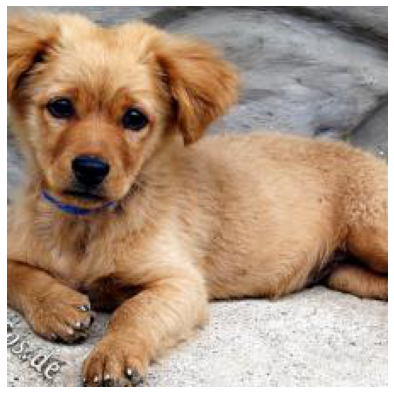

In [189]:
# Pick a random image from the Web.
# Make sure it's 224x224 image since VGG16 expects this size.
image = skimage.io.imread("http://lorempixel.com/224/224/animals/")
assert image.shape == (224, 224, 3), "Must be 224x224 RGB Image"
tensor_summary(image)
display_images([image], cols=2)

In [190]:
# Convert image to float
x = image.astype(np.float32)
# Make it a batch of one. The model expects a batch, not a single image
x = np.expand_dims(x, axis=0)
# Preprocess image. Convert RGB to BGR and subtract the ImageNet mean.
x = vgg16.preprocess_input(x)

In [191]:
# Classify the image
predictions = model.predict(x)
# We'll get a 1000 values. Print the first 10.
print(predictions[0][:10])

[8.4363698e-08 7.8116585e-08 7.5175119e-09 6.9326727e-09 3.7155463e-08
 1.4953766e-06 6.3727452e-07 1.8268278e-06 1.6611368e-05 1.6908170e-07]


shape: (1, 1000)  min: 3.437018225582733e-09  max: 0.7784823775291443
label index:  207


[[('n02099601', 'golden_retriever', 0.7784824),
  ('n02099712', 'Labrador_retriever', 0.037952814),
  ('n04409515', 'tennis_ball', 0.02490191)]]

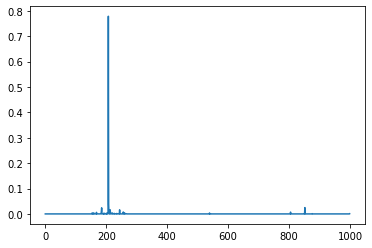

In [192]:
# The last layer is a 1D 1000-vector. Visualize as a bar chart.
plt.plot(read_layer(model, x, "predictions"))
# Find the largest confidence value. This corresponds to the label index.
label_index = np.argmax(predictions)
print("label index: ", label_index)
#顯示預測前三
vgg16.decode_predictions(predictions,top=3)

# Heatmap

In [193]:
step = 14
heatmap_x = []
for row in range(0, image.shape[0], step):
    for col in range(0, image.shape[1], step):
        new_image = image.copy()
        # Add a square patch. Using a bright color here to make it easier to see.
        new_image[row:row+step, col:col+step, :] = [250,128,128]
        heatmap_x.append(new_image)
heatmap_x = np.stack(heatmap_x)
heatmap_x.shape

(256, 224, 224, 3)

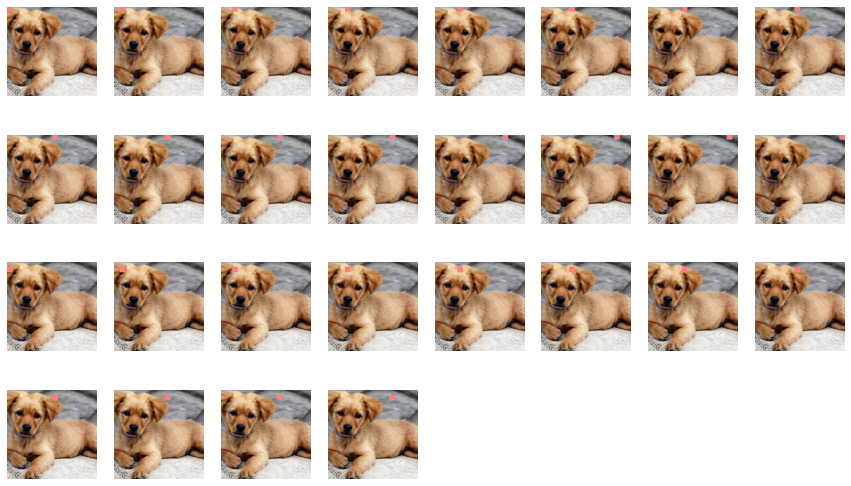

In [194]:
display_images(heatmap_x[:28], cols=8)

In [195]:
heatmap_y = model.predict(vgg16.preprocess_input(heatmap_x.astype(np.float32)))
tensor_summary(heatmap_y)

shape: (256, 1000)  min: 1.6851003925566488e-09  max: 0.8226268291473389


In [196]:
probs = heatmap_y[:, label_index]
tensor_summary(probs)

shape: (256,)  min: 0.5600227117538452  max: 0.8226268291473389


In [197]:
heatmap = (probs.max() - probs) / (probs.max()-probs.min())
heatmap = np.reshape(heatmap, (16, 16))
tensor_summary(heatmap)

shape: (16, 16)  min: 0.0  max: 1.0


shape: (16, 16)  min: 0.0  max: 1.0


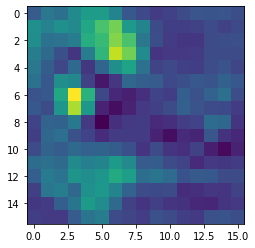

In [198]:
tensor_summary(heatmap)
_ = plt.imshow(heatmap)

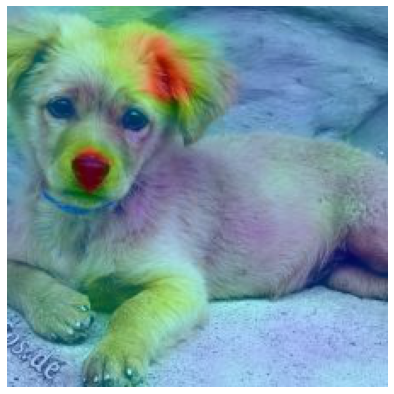

In [199]:

heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_RAINBOW)
superimposed_img = heatmap * 0.5 + image
display_images([superimposed_img],cols=2)

# Visualize the Weights

In [200]:
weights = model.get_layer("block1_conv1").get_weights()[0]
weights.shape, weights.min(), weights.max()

((3, 3, 3, 64), -0.67140007, 0.6085159)

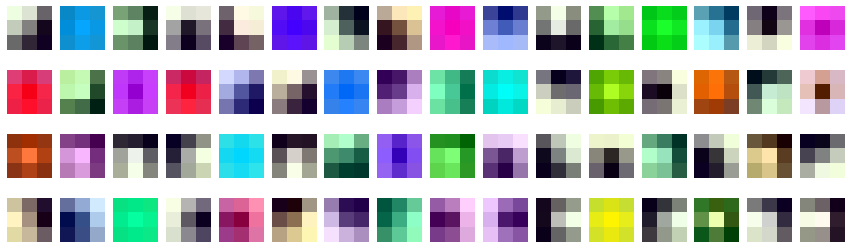

In [201]:
display_images([weights[:,:,::-1,i] for i in range(64)], cols=16, interpolation="none")

In [202]:
def read_layer(model, x, layer_name):
    """Return the activation values for the specifid layer"""
    # Create Keras function to read the output of a specific layer
    get_layer_output = K.function([model.layers[0].input], [model.get_layer(layer_name).output])
    outputs = get_layer_output([x])[0]
    tensor_summary(outputs)
    return outputs[0]
    
def view_layer(model, x, layer_name, cols=5):
    print(layer_name)
    outputs = read_layer(model, x, layer_name)
    display_images([outputs[:,:,i] for i in range(10)], cols=cols)

block1_conv1
shape: (1, 224, 224, 64)  min: 0.0  max: 693.0335693359375


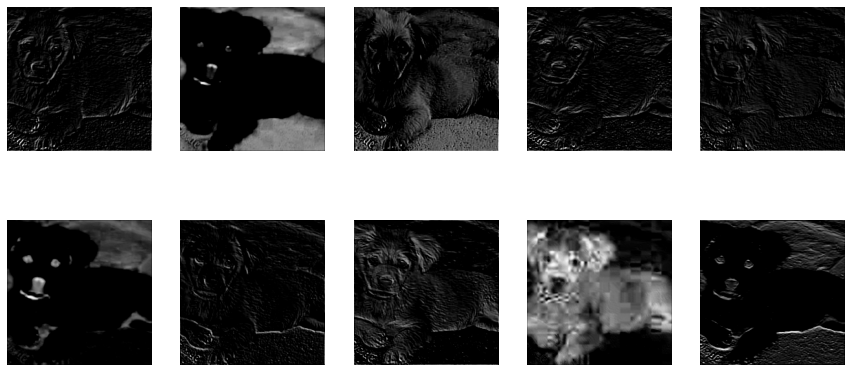

In [203]:
view_layer(model, x, "block1_conv1")

block1_conv2
shape: (1, 224, 224, 64)  min: 0.0  max: 2488.793701171875


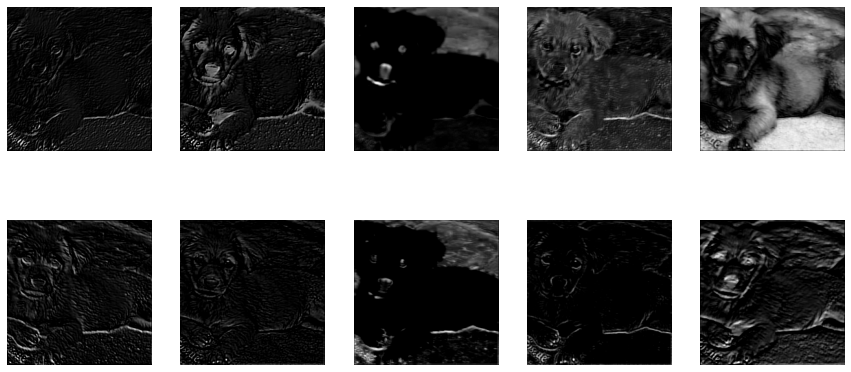

In [204]:
view_layer(model, x, "block1_conv2")

block2_conv1
shape: (1, 112, 112, 128)  min: 0.0  max: 4695.40380859375


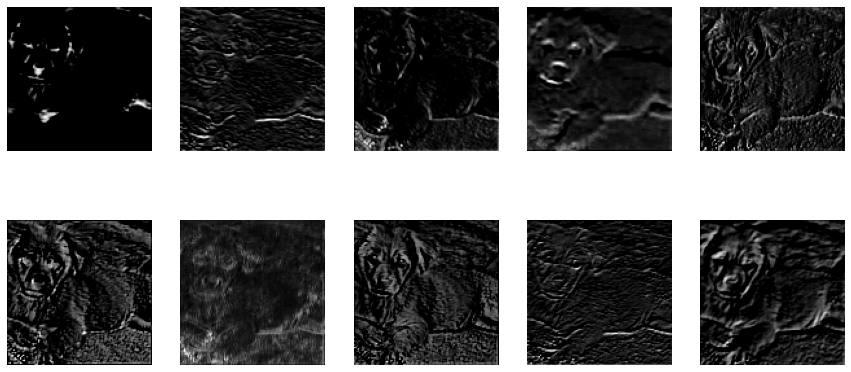

In [205]:
view_layer(model, x, "block2_conv1")

block3_conv1
shape: (1, 56, 56, 256)  min: 0.0  max: 7770.02587890625


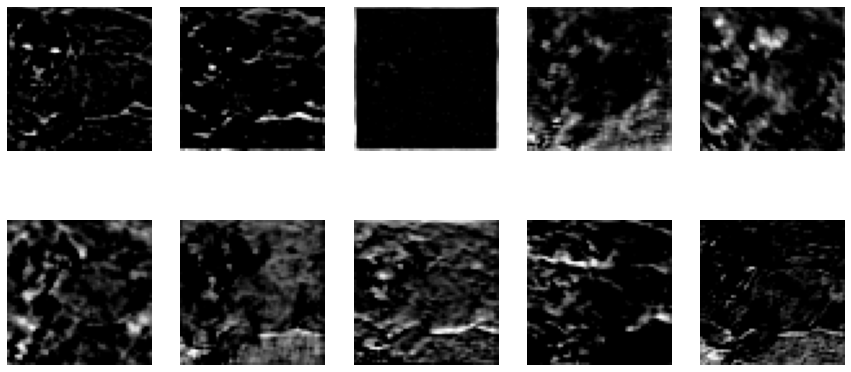

In [206]:
view_layer(model, x, "block3_conv1")

block4_conv1
shape: (1, 28, 28, 512)  min: 0.0  max: 8459.40234375


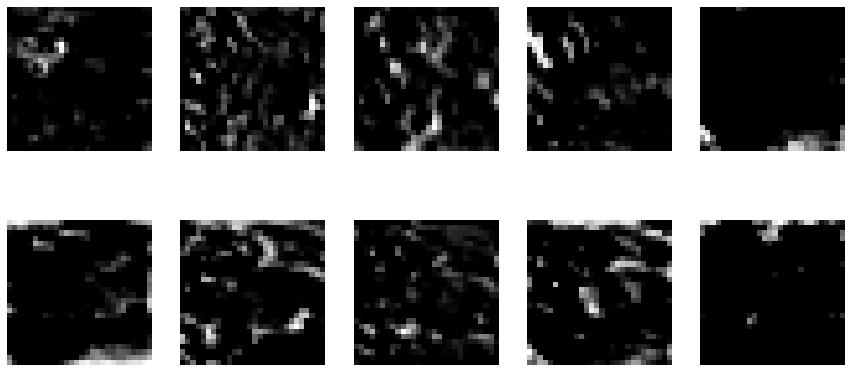

In [207]:
view_layer(model, x, "block4_conv1")

block5_conv3
shape: (1, 14, 14, 512)  min: 0.0  max: 558.773681640625


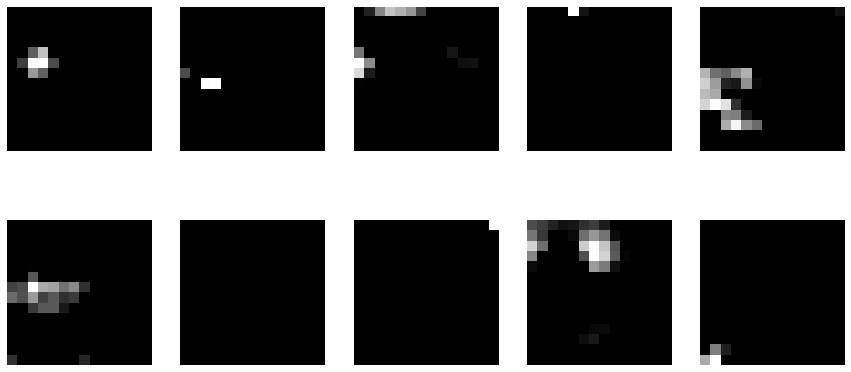

In [208]:
view_layer(model, x, "block5_conv3")